# Tasks: Feb-15

- **Exporting tables from Databricks to S3**

- The Following cell runs in databricks only

In [227]:
# dbutils is used to mount the S3 space as the data bricks drive.
import dbutils
from pyspark.sql import SQLContext

# Create a spark context
sqlContext = SQLContext(sc)

- The Following cell runs in databricks only

In [228]:
# Mount the S3 drive to data bricks
dbutils.fs.mount("s3n://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, 'dse-team4-2015'), "/mnt/%s" % 'mydata1')

# Data bricks
dbutils.fs.ls("/mnt/")

- The Following cell runs in databricks only

In [ ]:
# This cells runs in the databricks server
# allbuildingsensordata is a data bricks table that has data about all the tables.

allbuildingsensordata = sqlContext.sql("SELECT * FROM allbuildingsensordata")
allbuildingsensordata.write.format("com.databricks.spark.csv").save("dbfs:/mnt/mydata1/allbuildingsensordata")

### Imports

- Bokeh is used for plotting

In [229]:
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
import numpy as np
import pandas as pd
from bokeh.layouts import row
output_notebook()
import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

## Data Analysis of Signals for Room 2138

- Read the data into pandas dataframe
- Parse dates
- Sort by dates
- Separate the Zone temperature, Damper position, Actual supply flow, Actual cooling setpoint, Actual heating setpoint

### Observations

- All the data for zone temparature is nan for this room
- There is no actual supply flow data from June-2014 to Jan-2015
- Damper position data is available from Aug-2013 to Aug-2014
- Actual heating setpoint is available from Aug-2013 to Nov-2013
- Actual cooling set point is available from April-2014 to Nov-2014

In [6]:
# Read the DAta for room 2138 into the pandas dataframe.
df = pd.read_csv('data/rm2138_all.csv', names=['sensor_id', 'timestamp', 'value', 'room', 'template'],
                 parse_dates=['timestamp']).dropna().drop_duplicates().sort_values(by='timestamp')

# Separate the data for each template
zt = df[df.template == 'Zone Temperature'][['timestamp', 'value']]
dp = df[df.template == 'Damper Position'][['timestamp', 'value']]
asf = df[df.template == 'Actual Supply Flow'][['timestamp', 'value']]
acsp = df[df.template == 'Actual Cooling Setpoint'][['timestamp', 'value']]
ahsp = df[df.template == 'Actual Heating Setpoint'][['timestamp', 'value']]

### API for plotting using bokeh or matplotlib

In [7]:
def plot_signals(df, signal_list, bokeh=True, start_date=None, end_date=None, normalize=False):
    colors = ['#FB9A99', '#00FF00', '#0000FF', '#A52A2A']
    if bokeh:
        # Setup the figure for the plot for bokeh
        p = figure(x_axis_type="datetime", title="Various Signal values")
        p.grid.grid_line_alpha=0.3
        p.xaxis.axis_label = 'Date'
        p.yaxis.axis_label = 'value'
        p.legend.location = "top_right"
    else:
        # Setup the figure for the plot using matplotlib
        plt.figure(figsize=(22, 9))
        plt.title("Various Signals for Rm2138", fontsize=20)
        plt.xlabel("Date")
        plt.ylabel("value")
    
    for i, signal in enumerate(signal_list):
        data = df[df.template == signal]
        if not len(data):
            print "No data for signal", signal
            continue
        
        # Flasg to perform normalization.
        if normalize:
            data['value'] = (data['value'] - data['value'].min()) / (data['value'].max() - data['value'].min())
        
        # Filter based on dates
        if not start_date == None:
            data = data[(data.timestamp.dt.date >= pd.to_datetime(start_date).date()) &
                (data.timestamp.dt.date <= pd.to_datetime(end_date).date())]
            if not len(data):
                print "Invalid date range. no data found for ", signal
                continue
        
        # Plotting based on bokeh / matplotlib
        if bokeh:
            p.line(data.timestamp, data.value, color=colors[i], legend=signal)
        else:
            plt.plot(data.timestamp, data.value, color=colors[i], label=signal)

    if bokeh:
        show(gridplot([[p]], plot_width=900, plot_height=500))
    else:
        plt.legend()

#### Timeseries Vs Signal Value Plot using Bokeh

In [8]:
plot_signals(df, ['Actual Supply Flow', 'Damper Position', 'Actual Cooling Setpoint', 'Actual Heating Setpoint'])

#### Timeseries Vs Signal Value  plot using Matplotlib

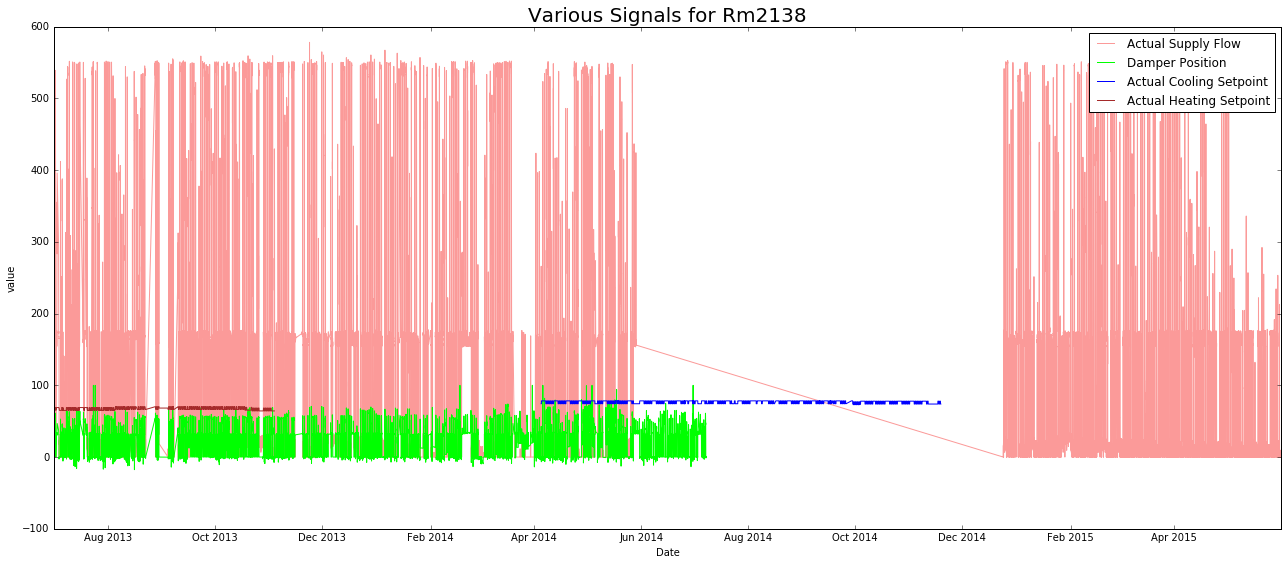

In [9]:
plot_signals(df, ['Actual Supply Flow', 'Damper Position', 'Actual Cooling Setpoint', 'Actual Heating Setpoint'], bokeh=False)

#### Normalized Plot of signals

- Normalization will convert all the signals to 0 - 1 range
- This will help us to understand the increae or decrease properly.

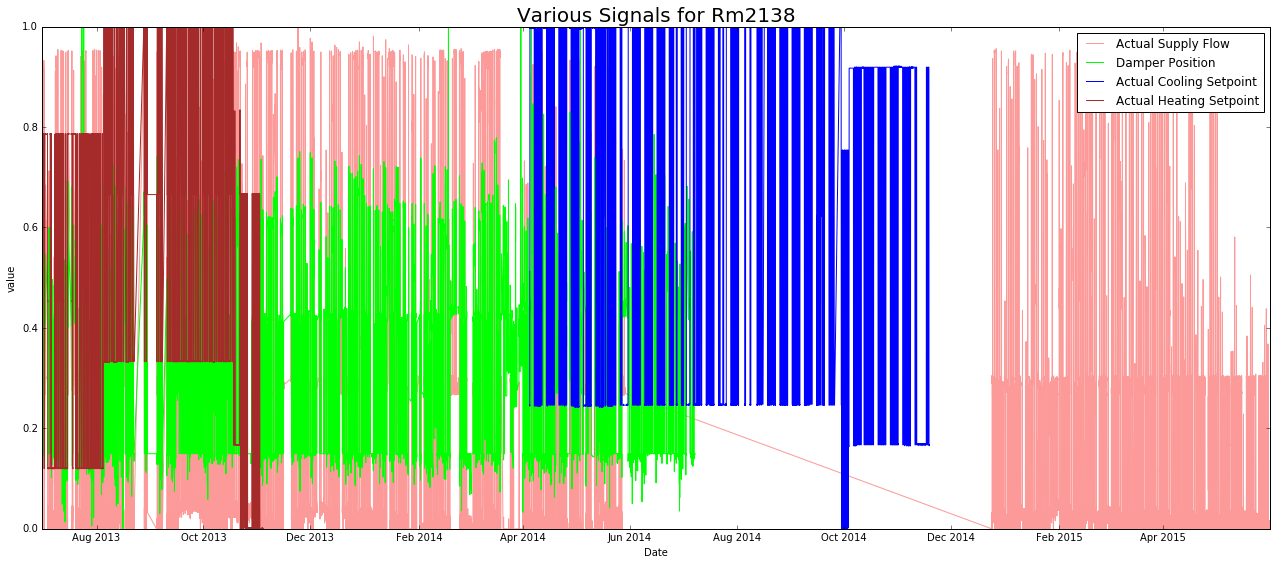

In [230]:
plot_signals(df, ['Actual Supply Flow', 'Damper Position', 'Actual Cooling Setpoint', 'Actual Heating Setpoint'],
             bokeh=False, normalize=True)

### Plot Signals for a week range to identify Patterns
    ### Observation
        1. We see that in a given week the Actual Supply Flow adn Damper Position have the same fluctuation and looks highly
           correlated
        2. Damper Position look static mostly throughout

Invalid date range. no data found for  Actual Heating Setpoint


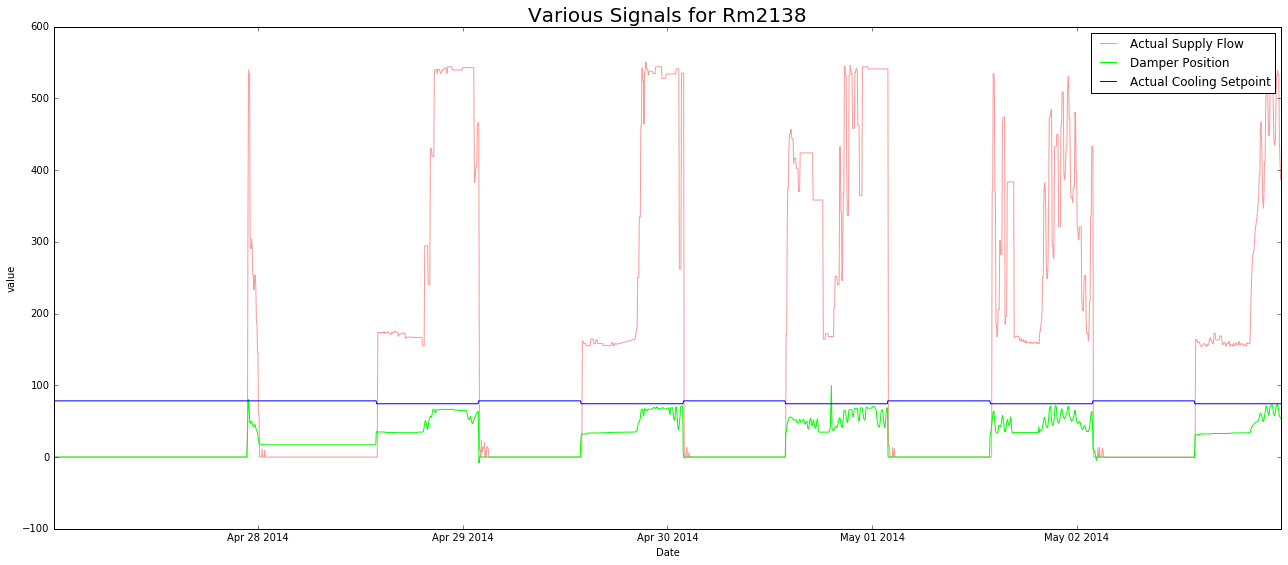

In [232]:
plot_signals(df, ['Actual Supply Flow', 'Damper Position', 'Actual Cooling Setpoint', 'Actual Heating Setpoint'], bokeh=False,
            start_date="2014-04-27", end_date="2014-05-02",normalize=False)

In [226]:
start_date, end_date = "2014-05-26", "2014-05-26"
df[(df.timestamp.dt.date >= pd.to_datetime(start_date).date()) &
                (df.timestamp.dt.date <= pd.to_datetime(end_date).date())]

### Prepare data to have day of the week, Hour of the day and time of the date

In [105]:
df["hour"] = df.timestamp.dt.hour
df["day"]= df.timestamp.dt.dayofweek
df["time"] = df.timestamp.dt.time
df.head()

sensor_id           timestamp  value  \
1197594  f5c75a04-77dd-11e2-83c4-00163e005319 2013-07-01 00:47:53  65.02   
1197597  f5c75a04-77dd-11e2-83c4-00163e005319 2013-07-01 00:53:09  65.01   
1197600  f5c75a04-77dd-11e2-83c4-00163e005319 2013-07-01 00:58:07  65.01   
1197603  f5c75a04-77dd-11e2-83c4-00163e005319 2013-07-01 01:00:30  65.01   
1197606  f5c75a04-77dd-11e2-83c4-00163e005319 2013-07-01 01:02:29  65.01   

            room                 template  hour  day      time  
1197594  Rm-2138  Actual Heating Setpoint     0    0  00:47:53  
1197597  Rm-2138  Actual Heating Setpoint     0    0  00:53:09  
1197600  Rm-2138  Actual Heating Setpoint     0    0  00:58:07  
1197603  Rm-2138  Actual Heating Setpoint     1    0  01:00:30  
1197606  Rm-2138  Actual Heating Setpoint     1    0  01:02:29

### Plot  Average Signal strength of the room at each hour across days of week
 #### Observations
         1. Signal Actual Supply flow is >300 at Midnight (Tuesday to Saturday) almost Monday to Friday
         2. Signal Actual Supply flow is > 180 at 3 PM (Monday to Friday)
         3. Signal Actual Supply flow is >300 at 9 PM (Monday to Friday)
         4. Signal Actual Supply flow is >150 at 6 PM (Monday to Friday)
         5. Damper Position is highly correlated to Actual Supply Flow at all times
         6. Actual Cooling Set Point is almost static at all times of the day of week

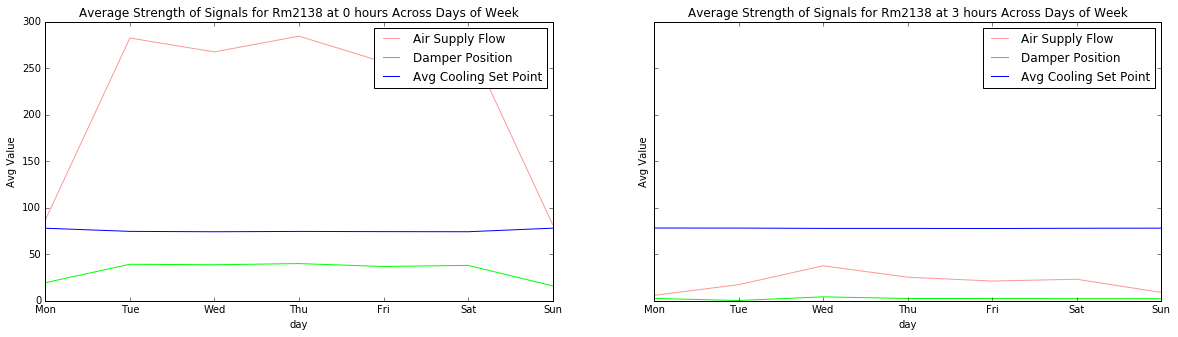

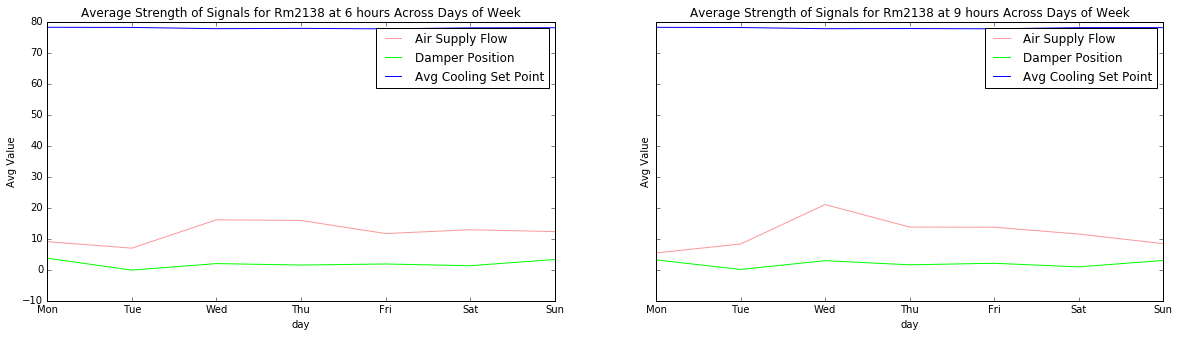

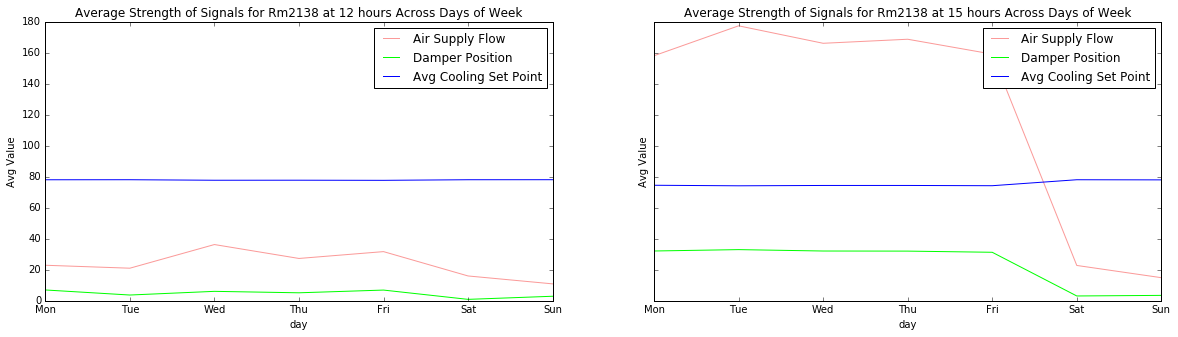

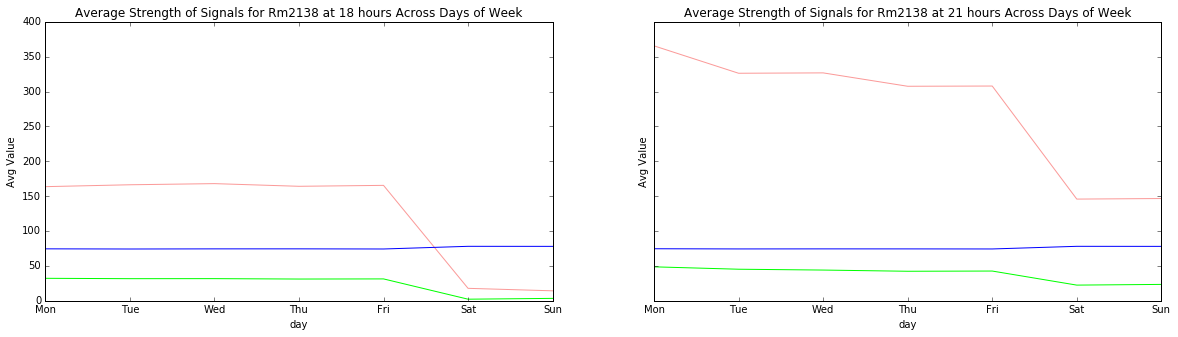

In [220]:
def plot_hour(hour, ax=None):   
        # Average on template, day and hour
    Avg_df = df.groupby(["template","day","hour"]).value.mean().reset_index()
        # Add filter on specific hour
    Avg_df = Avg_df[(Avg_df.hour==hour)]
    # Specify dataframe for each signal    
    ASF = Avg_df[Avg_df.template == "Actual Supply Flow"]
    ACSP = Avg_df[Avg_df.template == "Actual Cooling Setpoint"]
    AHSP = Avg_df[Avg_df.template == "Actual Heating Setpoint"]
    DP = Avg_df[Avg_df.template == "Damper Position"]
    if ax is None:
        ax = plt.gca()
    # Add Label        
    Days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    tit = "Average Strength of Signals for Rm2138 at %d hours Across Days of Week"%(hour)
    ax.plot(ASF['day'],ASF['value'], color='#FB9A99',label='Air Supply Flow')
    ax.plot(DP['day'],DP['value'],color='#00FF00',label='Damper Position')
    ax.plot(ACSP['day'],ACSP['value'],color='#0000FF',label='Avg Cooling Set Point')
    ax.set_xticklabels(Days)
        # Add title
    ax.set_title(tit)
    ax.set_xlabel("day")
    ax.set_ylabel("Avg Value")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plot_hour(0,ax1)
ax1.legend()
plot_hour(3,ax2)
ax2.legend()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plot_hour(6,ax1)
ax1.legend()
plot_hour(9,ax2)
ax2.legend()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plot_hour(12,ax1)
ax1.legend()
plot_hour(15,ax2)
ax2.legend()
f, (ax7, ax8) = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plot_hour(18,ax7)
ax1.legend()
plot_hour(21,ax8)
ax2.legend()



### Plot  Average Signal strength of the room for days of week at each time interval
#### Observation
    1. On Tuesdays, Signal Actual Supply flow never went to Zero After 2 PM until midnight
    2. On Mondays, Signal Actual Supply flow has huge spikes around Noon
    3. On Saturdays and Sundays, Signal Actual Supply flow had few spikes around 7 AM

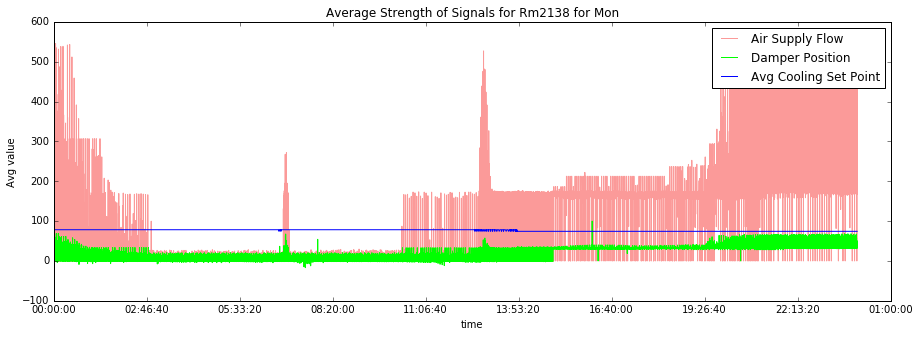

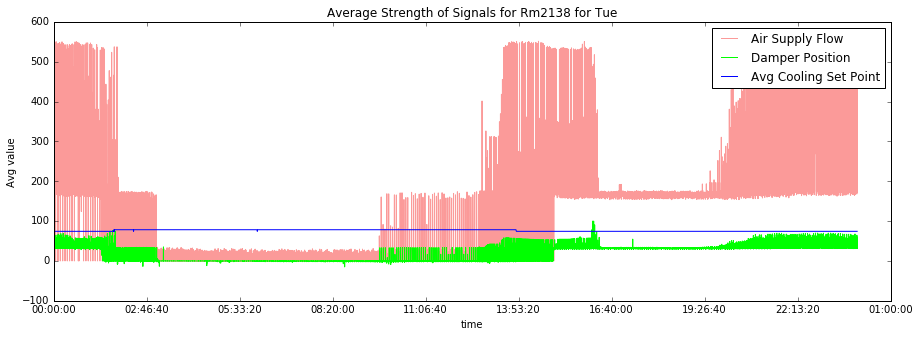

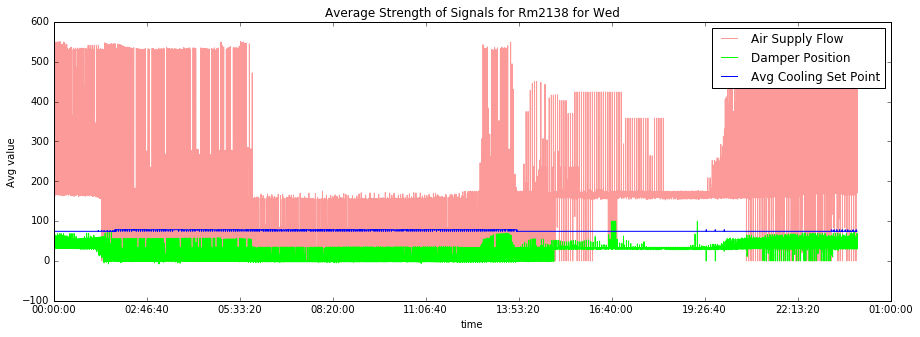

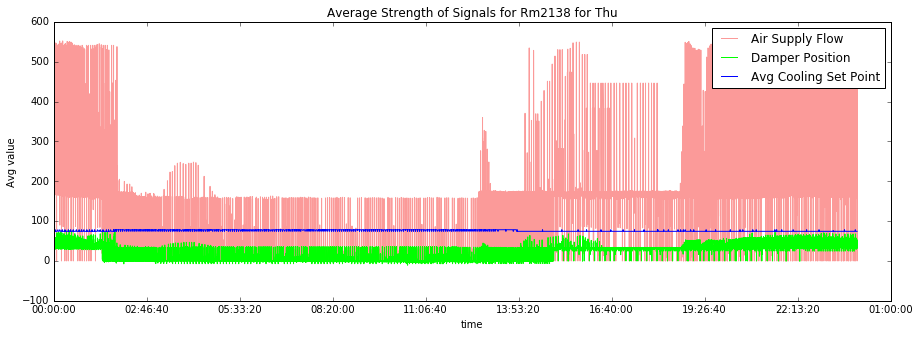

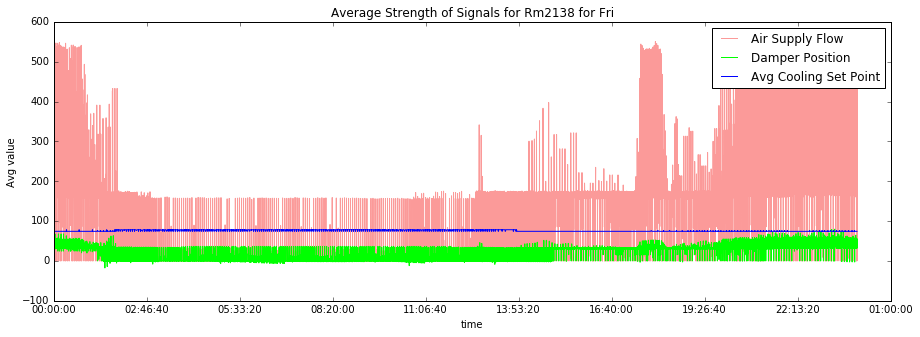

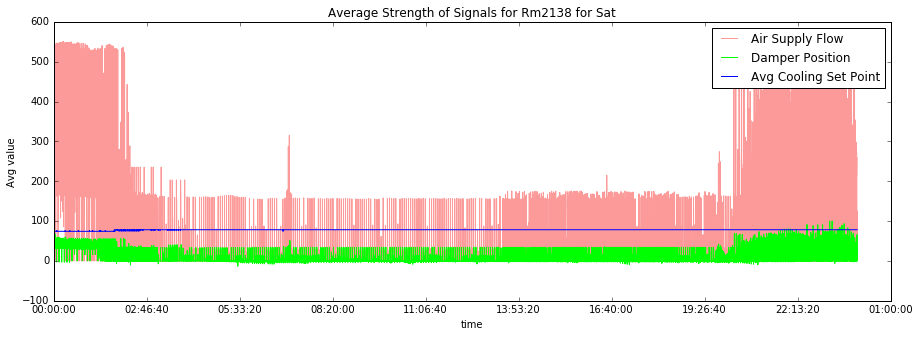

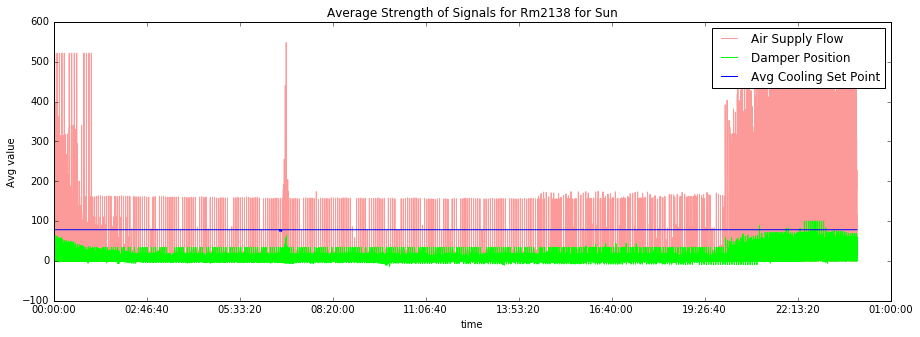

In [221]:
def plot_day(day):
    # Add Label
    label = {"Mon":0,"Tue":1,"Wed":2,"Thu":3,"Fri":4,"Sat":5,"Sun":6}
    # Add filter on specific date
    dfs = df[df.timestamp.dt.date<pd.to_datetime("2014-06-30").date()]
    # Average on template, day and hour
    Avg_df = dfs.groupby(["template","day","time"]).value.mean().reset_index() 
    # Pass the day of the week
    Avg_df = Avg_df[(Avg_df.day==label[day])]
    # Specify dataframe for each signal    
    ASF = Avg_df[Avg_df.template == "Actual Supply Flow"]
    ACSP = Avg_df[Avg_df.template == "Actual Cooling Setpoint"]
    AHSP = Avg_df[Avg_df.template == "Actual Heating Setpoint"]
    DP = Avg_df[Avg_df.template == "Damper Position"]
    plt.figure(figsize=(15,5))
    #plot the signals    
    plt.plot(ASF['time'],ASF['value'], color='#FB9A99',label='Air Supply Flow')
    plt.plot(DP['time'],DP['value'],color='#00FF00',label='Damper Position')
    plt.plot(ACSP['time'],ACSP['value'],color='#0000FF',label='Avg Cooling Set Point')
    plt.title("Average Strength of Signals for Rm2138 for %s"%(day))
    plt.xlabel("time")
    plt.ylabel("Avg value")
    plt.legend()
plot_day("Mon")
plot_day("Tue")
plot_day("Wed")
plot_day("Thu")
plot_day("Fri")
plot_day("Sat")
plot_day("Sun")

### Plot Average Signal Strength of the room at each hour of the day.
       1. Signals Air Supply flow and Damper Position raises sharply after 10 AM on Weekdays(Mon to Friday)
       2. Signals Air Supply flow and Damper Position raises between 8 PM to 4 AM on Saturdays
       3. Signals Air Supply flow and Damper Position raises between 8 PM to 1 AM on Sundays

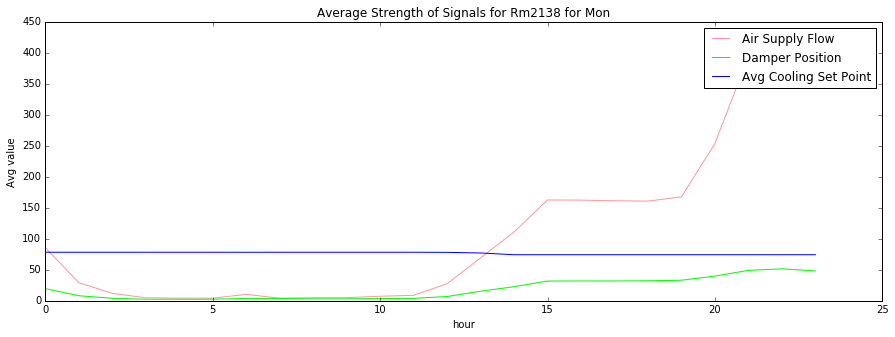

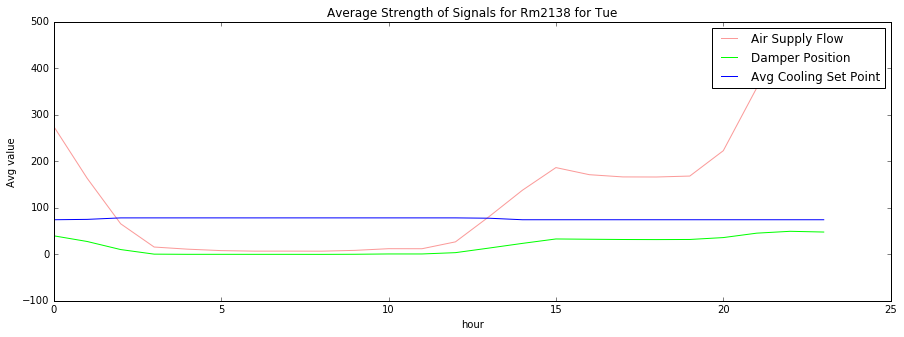

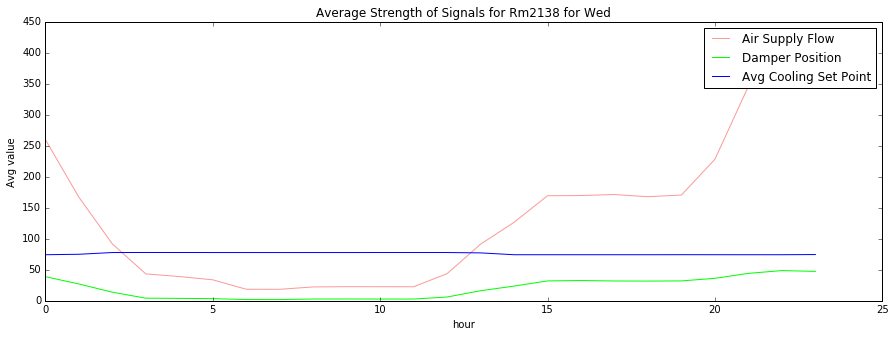

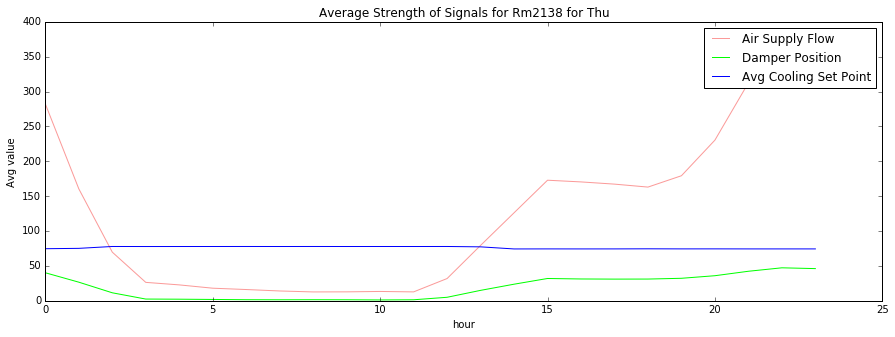

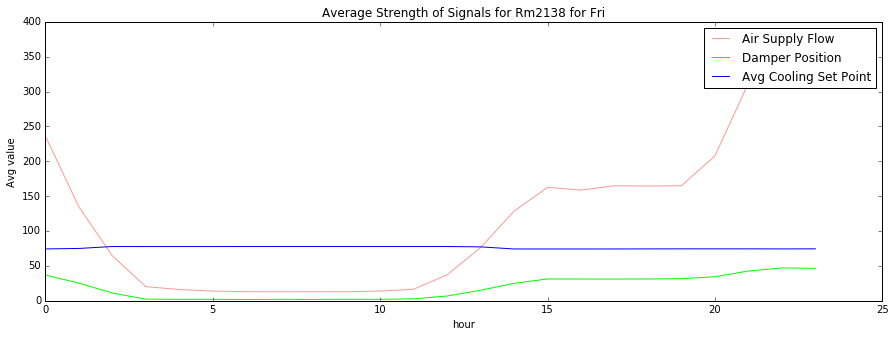

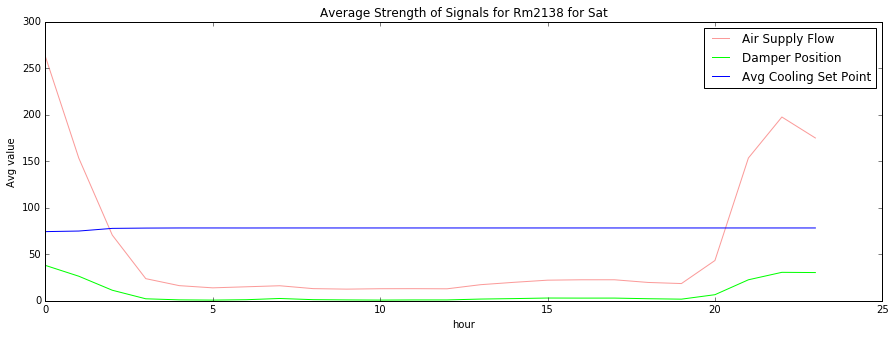

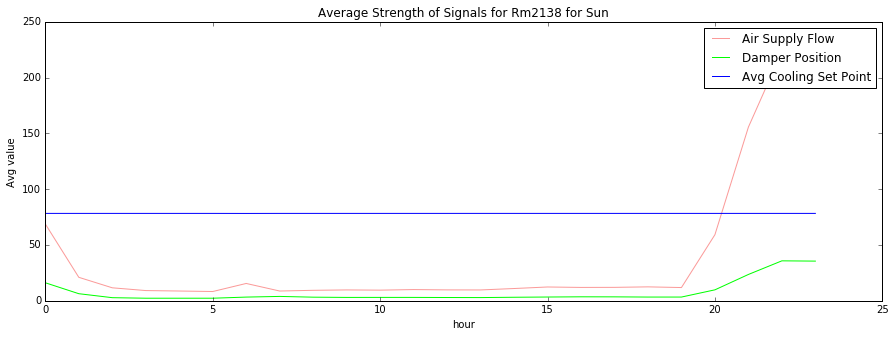

In [222]:
def plot_day(day):
    # Add Label
    label = {"Mon":0,"Tue":1,"Wed":2,"Thu":3,"Fri":4,"Sat":5,"Sun":6}
    # Add filter on specific date
    dfs = df[df.timestamp.dt.date<pd.to_datetime("2014-06-30").date()]
    # Average on template, day and hour
    Avg_df = dfs.groupby(["template","day","hour"]).value.mean().reset_index() 
    # Pass the day of the week
    Avg_df = Avg_df[(Avg_df.day==label[day])]
    # Specify dataframe for each signal
    ASF = Avg_df[Avg_df.template == "Actual Supply Flow"]
    ACSP = Avg_df[Avg_df.template == "Actual Cooling Setpoint"]
    AHSP = Avg_df[Avg_df.template == "Actual Heating Setpoint"]
    DP = Avg_df[Avg_df.template == "Damper Position"]
    plt.figure(figsize=(15,5))
    #plot the signals
    plt.plot(ASF['hour'],ASF['value'], color='#FB9A99',label='Air Supply Flow')
    plt.plot(DP['hour'],DP['value'],color='#00FF00',label='Damper Position')
    plt.plot(ACSP['hour'],ACSP['value'],color='#0000FF',label='Avg Cooling Set Point')
    plt.title("Average Strength of Signals for Rm2138 for %s"%(day))
    plt.xlabel("hour")
    plt.ylabel("Avg value")
    plt.legend()
plot_day("Mon")
plot_day("Tue")
plot_day("Wed")
plot_day("Thu")
plot_day("Fri")
plot_day("Sat")
plot_day("Sun")

### Plot the Signal for any given date based on its Absolute value
    ### Observation
        1. In this case where we find 05/27/2014 being a weekday Signals Actual supply flow and Actual Cooling setpoint spikes 
           up after 3 PM untill 1 AM following day

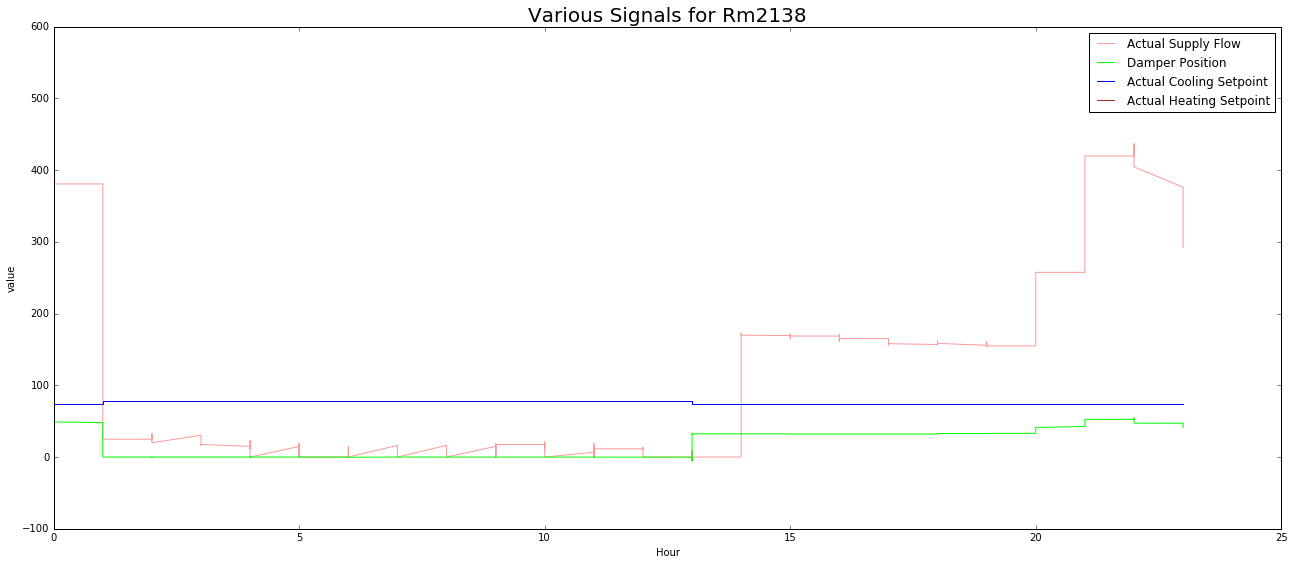

In [223]:
def plot_date(date):
    colors = ['#FB9A99', '#00FF00', '#0000FF', '#A52A2A']
    signal_list = ['Actual Supply Flow', 'Damper Position', 'Actual Cooling Setpoint', 'Actual Heating Setpoint']
    # Setup the figure for the plot using matplotlib
    plt.figure(figsize=(22, 9))
    plt.title("Various Signals for Rm2138", fontsize=20)
    plt.xlabel("Hour")
    plt.ylabel("value")


    start_hour, end_hour = 0, 24
    for i, signal in enumerate(signal_list):

        data = df[df.template == signal]
        if not len(data):
            print "No data for signal for hours between dates", signal
            continue
        data = data[(data.timestamp.dt.date == pd.to_datetime(date).date())
              &  (data.hour >= start_hour) & (data.hour < end_hour) ]
        plt.plot(data.hour, data.value, color=colors[i], label=signal)
        plt.legend()
data_date = "2014-05-27"
plot_date(data_date)        

###  Observation
      2. Whereas on 05-25-2014 being weekend sunday, the Signals Actual supply flow and damper position have remained low untill          10 PM and spikes only between 10 PM to 1 AM

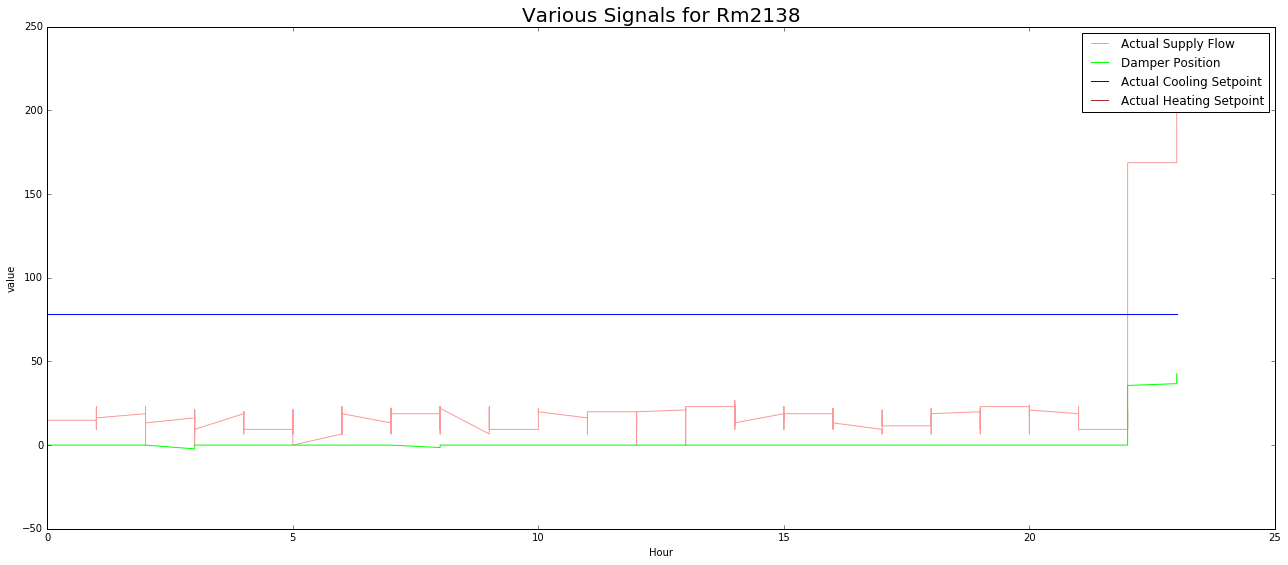

In [224]:
data_date = "2014-05-25"
plot_date(data_date)        